# Building Permit Metrics of San Francisco

## Packages & Raw Data Import

In [1]:
import geopandas as gpd
import pandas as pd
import numpy as np

import os 
os.chdir(r'C:\Users\nelms\Documents\Penn\CPLN-680\Permit_Metrics')

In [2]:
DATA_FOLDER = r'data'
META_FOLDER = DATA_FOLDER + r'\meta'
RAW_FOLDER = DATA_FOLDER + r'\raw'
CLEAN_FOLDER = DATA_FOLDER + r'\clean'

Import in San Francisco Neighborhoods and Quadrants

In [3]:
project_crs = 'EPSG:7132'
path = RAW_FOLDER + r'\georeference\sf_neighborhoods.geojson'
sfnhood = gpd.read_file(path).to_crs(project_crs)
project_crs = sfnhood.crs

path = RAW_FOLDER + r'\georeference\sf_quadrants.geojson'
sfquad = gpd.read_file(path).to_crs(project_crs)

path = CLEAN_FOLDER + r'\sf_2010censusblock.geojson'
sfblock = gpd.read_file(path).to_crs(project_crs)

### Import San Francisco Planning Permits 2016-2022
Pre-Cleaned Accela Permits from SF Open Data Portal ([pre-2013](https://data.sfgov.org/Housing-and-Buildings/Building-Permits-before-January-1-2013/)
 or [post-2013](https://data.sfgov.org/Housing-and-Buildings/Building-Permits-on-or-after-January-1-2013/))

Column Metadata to rename columns & determine which ones to keep

In [ ]:
path = META_FOLDER + r'\sf_planning_permit_fields.xlsx'
sfp_meta = pd.read_excel(path)

new_col_names = {
    old.lower():new for old,new in sfp_meta[['Column Name','New Name']].values 
    if type(new) == str
}
keep_cols = sfp_meta.loc[sfp_meta['Keep']=='y', 'Column Name'].str.lower().to_list() + ['geometry']

Import in geojson of geolocated & cleaned permits

In [ ]:
import pandas as pd
import geopandas as gpd

path = RAW_FOLDER + r'\sf_planning_permits_20220321.geojson'
sfp_full = gpd.read_file(path)

Prepare Dataset:
1. Filter by 'Project Profile' permits *(which are the 'main' permit)* & columns
2. Rename columns with metadata
3. Set integer & date type columns
4. Filter by permits with some form of proposed units
5. Remove Empty Geometry
6. Filter permits by:
    * A Start Date of Mid-2014
    * A Close Date of Mid-2015
7. Join to Neighborhoods

In [ ]:
# 1. FILTER BY PERMIT TYPE
prj_filt = sfp_full['record_type']=='PRJ'
sfp = sfp_full[prj_filt][keep_cols].copy()

# 2. RENAME COLUMNS
sfp.columns = [
    new_col_names[c] if c in new_col_names.keys()
    else c
    for c in list(sfp)
]

# 3. SET DATA TYPES
## INTEGERS
unit_col = [c for c in list(sfp) if '#' in c]
sfp[unit_col] = sfp[unit_col].astype(float).astype(int)
## DATES
date_col = [c for c in list(sfp) if 'date' in c]
sfp[date_col] = sfp[date_col].apply(pd.to_datetime)

# 4. FILTER BY UNITS
all_filt = sfp['#units_prop']>0
mr_filt = sfp['#units_prop_mr']>0
sfp = sfp[all_filt|mr_filt]

# 5. REMOVE EMPTY GEOMETRY
sfp = sfp[~sfp['geometry'].is_empty] 
sfp_all = sfp.copy()

# 6. SET DATES 
## OPEN DATE OF 2014
date_open = '2014Q3'
open_filt = sfp['date_open']>date_open
## CLOSE DATE OF MID-2015
date_close = '2015Q3'
close_filt = sfp['date_close'].dt.to_period("Q")>=date_close
sfp = sfp[open_filt&close_filt]

# 7. JOIN TO NEIGHBORHOODS
sfp = sfp.sjoin(sfnhood).drop(columns='index_right')

### Building Permits

In [28]:
path = RAW_FOLDER + r'\sf_building_permits_20220411.csv'
sfb_full = pd.read_csv(path)

path = META_FOLDER + r'\sf_building_permit_fields.xlsx'
sfb_meta = pd.read_excel(path)
sfb_meta = sfb_meta.loc[sfb_meta['keep']=='y'].set_index('name')['new_name'].to_dict()

#for c in sfb_meta.keys(): 
#    if c not in list(sfb_full):
#        print(c)

sfb_full = sfb_full[sfb_meta.keys()].rename(columns=sfb_meta).sort_values('date_issued')
for c in [c for c in sfb_meta.values() if 'date' in c]:
    sfb_full[c] = pd.to_datetime(sfb_full[c])

wgs84_crs = "epsg:4326"

sfbg = sfb_full[['pid', 'rid', 'geometry']]
sfbg = gpd.GeoDataFrame(sfbg, geometry=gpd.GeoSeries.from_wkt(sfbg['geometry']), crs=wgs84_crs).to_crs(project_crs)
sfbg = gpd.overlay(sfbg, sfblock, how='intersection')
sfbg.head()

sfb_full = sfb_full.set_index(['pid','rid']).join(sfbg[[c for c in list(sfbg) if c != 'geometry']].set_index(['pid','rid'])).reset_index(drop=False)

date_col = 'date_issued'
year_bins = ['2000', '2005', '2010', '2015', '2020'] 
year_bins = pd.to_datetime(year_bins)
year_labels = ['00-04', '05-09', '10-14', '15-19']
sfb_full['5years'] = pd.cut(sfb_full[date_col], year_bins, labels=year_labels, include_lowest=True)

sfb_full.head()

C:\ProgramData\Miniconda3\envs\permit_metrics\lib\site-packages\openpyxl\worksheet\header_footer.py:48: UserWarning: Cannot parse header or footer so it will be ignored
  warn("""Cannot parse header or footer so it will be ignored""")


,pid,rid,date_start,desc,status,units_prop,use_prop,date_status,geometry,date_issued,block_id,geoid10,5years
0,9908229S,836112162081,1999-04-28,erect a three story fourteen unit residential ...,complete,14,apartments,2003-05-14,POINT (-122.41241836934992 37.756039544888395),2001-01-02,60750228033004,06075022803,00-04
1,200002222441,805277386263,2000-02-22,erect 2 story single family dwelling,complete,1,1 family dwelling,2002-08-06,POINT (-122.46369767113859 37.74514388048755),2001-01-02,60750304005005,06075030400,00-04
2,200002222434,805157146486,2000-02-22,erect a new two story single family dwelling,complete,1,1 family dwelling,2002-08-06,POINT (-122.4636154847457 37.74520807711159),2001-01-02,60750304005005,06075030400,00-04
3,9908229S,836111162082,1999-04-28,erect a three story fourteen unit residential ...,complete,14,apartments,2003-05-14,POINT (-122.41253760625708 37.756031983169024),2001-01-02,60750228033004,06075022803,00-04
4,200003305890,80903197856,2000-03-30,"to erect 4 stories, 3 family dwelling",complete,3,apartments,2003-09-26,POINT (-122.48551931234834 37.78410694871072),2002-01-02,60750427003008,06075042700,00-04


In [29]:
sfbb

,geoid10,geometry,5years,units_prop,rid,unit_bins
block_id,,,,,,
60750101002018,06075010100,"POLYGON ((171755.978 99144.169, 171409.981 988...",00-04,1426.0,50.0,100+
60750101002018,06075010100,"POLYGON ((171755.978 99144.169, 171409.981 988...",05-09,17.0,3.0,10-24
60750101002018,06075010100,"POLYGON ((171755.978 99144.169, 171409.981 988...",10-14,0.0,0.0,0
60750101002018,06075010100,"POLYGON ((171755.978 99144.169, 171409.981 988...",15-19,13.0,1.0,10-24
60750102003008,06075010200,"MULTIPOLYGON (((166627.256 98431.121, 166644.5...",00-04,6.0,4.0,1-9
...,...,...,...,...,...,...
60759806001062,06075980600,"MULTIPOLYGON (((179971.229 71330.930, 180037.3...",15-19,163.0,72.0,100+
60759809001128,06075980900,"POLYGON ((178846.227 75644.802, 178634.338 751...",00-04,25.0,3.0,10-24
60759809001128,06075980900,"POLYGON ((178846.227 75644.802, 178634.338 751...",05-09,2.0,2.0,1-9


## EXPLORATORY DATA ANALYSIS

<AxesSubplot:xlabel='date_issued'>

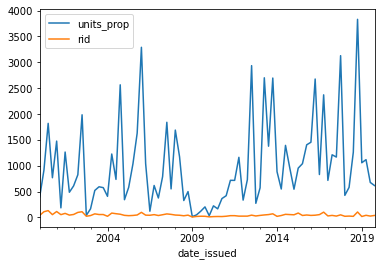

In [6]:
sfbb = sfb_full.copy()
date_col = 'date_issued'
period = 'Q'
sfbb[date_col] = sfbb[date_col].dt.to_period(period)
sfbb = sfbb.groupby(date_col).agg({
    'units_prop':'sum', 
    'rid':'count'
    })
sfbb.plot()

#sfb_full.groupby(focus_col).agg({
#    'units_prop':'sum', 'rid':'count'
#})['rid'].plot.bar()

In [17]:
def plot_labels(focus_gdf, label_col, ax, zorder=8):
    xylabel = zip(focus_gdf.geometry.centroid.x, focus_gdf.geometry.centroid.y, focus_gdf[label_col])
    for x, y, label in xylabel:
        ax.annotate(
            label, xy=(x, y), 
            #xytext=(3, 3), #textcoords="offset points",
            fontsize='large',
            fontweight='bold',
            zorder=zorder
            )
def plot_quads(ax, zorder=8):
    plot_labels(sfquad, 'quad', ax, zorder=zorder)

def get_cmap(data_list, cmap):
    def get_colors(n, cmap):
        from mycolorpy import colorlist as mcp
        color1=mcp.gen_color(cmap=cmap,n=n)
        return color1
    light_grey = '#D3D3D3'
    cmap = [light_grey] + get_colors(len(data_labels)-1, cmap)
    return {v:c for v,c  in zip(data_labels, cmap)}

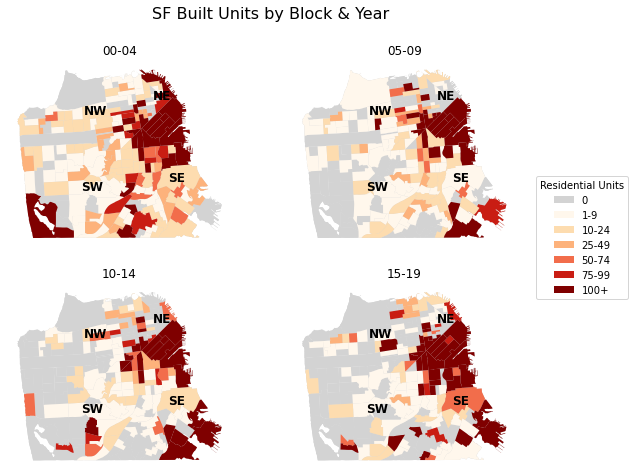

In [ ]:
ax = sfblock.plot(color='lightgrey', zorder=5)
sfbg.plot(
    ax=ax, marker='*', color='lightblue', markersize=5,
    zorder=7)

gpd.overlay(sfbg, sfblock, how='difference').plot(
    ax=ax, marker='*', color='darkred', markersize=5,
    zorder=8)

In [ ]:
#sfb = pd.concat([
#    sfb_pre13[sfb_meta.keys()],
#    sfb_post13[sfb_meta.keys()],
#    ]).rename(columns=sfb_meta)


In [ ]:
import seaborn

date_col = 'date_status'

sfb_plot = sfb[[date_col, 'units_prop', 'status', 'pid']]
sfb_plot[date_col] = sfb_plot[date_col].dt.to_period("Y").astype(str)

sfb_plot = sfb_plot.groupby([
    date_col, 'status'
    ]).agg({'units_prop':'sum', 'pid':'count'}).reset_index(drop=False)

seaborn.relplot(
    data=sfb_plot, 
    x=date_col, y='pid', hue='status', 
    aspect=1.61, kind="line"
    )


In [ ]:
approved_status = [
    'complete', 'issued',
    'filing', 'filed', 'disapproved', 'reinstated', 'appeal',
    'approved'
]

sfb.loc[sfb['status'].isin(approved_status)].plot()

## Exploratory Data Analysis

In [ ]:
import matplotlib.pyplot as plt
plt.rcParams["figure.autolayout"] = True

date_open = '2014Q3'
date_close = '2015Q3'

fig  = plt.figure(figsize = (8,6))
ax = fig.add_subplot(111)

def date_group(date_col, period = 'Q', group_df = sfp_all):
    return group_df.sort_values(date_col).groupby(group_df[date_col].dt.to_period(period))['id'].count()

date_col = 'date_open'
open_df = date_group(date_col)
open_df.plot(ax=ax, kind="line", label='Permits Opened')
#date_group(date_col, period="Y").plot(ax=ax, color='black', kind="bar")

date_col = 'date_close'
close_df = date_group(date_col)
close_df.plot(ax=ax, color='red', kind="line", label='Permits Closed')

ax.set_xlim(['2013Q3',None])
ax.set_ylim([0,None])

col = 'darkblue'
ax.vlines(
    x=date_open, ymin=0, ymax=max(open_df), colors=col, ls=':',
    label = 'Open Date Cutoff')
#ax.hlines(y=max(open_df), xmin=date_open, xmax=max(open_df.index), colors=col, ls=':')

col = 'maroon'
ax.vlines(
    x=date_close, ymin=0, ymax=max(close_df), colors=col, ls=':',
    label = 'Close Date Cutoff'
    )
#ax.hlines(y=max(close_df), xmin=date_close, xmax=max(close_df.index), colors=col, ls=':')

ax.set_xlabel('Quarters')
ax.set_ylabel('Count of Permits')
ax.legend(loc='best')

plt.show()

In [ ]:
#sfp[sfp['date_open']>='2015-01-01'].count()
#sfp[sfp['date_open']<'2015-01-01'].count()

sfp['date_openclose'] = sfp['date_open'].astype(str) + sfp['date_close'].astype(str)

sfp['length'] = (sfp['date_close'] - sfp['date_open']).dt.days
#(sfp['length']/365).hist()

long_plot = sfp.dropna(subset=['date_open','date_close'])

#fig  = plt.figure(figsize = (8,6))
#ax = fig.add_subplot(111)

period = 'Q'
#ax.barh(
#    long_plot.date_open.dt.to_period(period), 
#    long_plot.date_close.dt.to_period(period), 
#    left=long_plot.date_open.dt.to_period(period))


In [ ]:
a = sfp['date_app_acc'].dropna().count()
t = len(sfp)

a/t

unit_max = 100000
sjp_join = sfp[sfp['#units_prop']<unit_max].copy()

sfp_nhood = sjp_join.groupby('nhood')['id'].count().to_dict()
sfnhood['permit_count'] = sfnhood['nhood'].map(sfp_nhood).fillna(value=0).astype(int)


sfp_unit = sjp_join.groupby('nhood')['#units_prop'].sum().to_dict()
sfnhood['unit_prop_count'] = sfnhood['nhood'].map(sfp_unit).fillna(value=0)

sjp_join['unit_per_permit'] = sjp_join['#units_prop']/1
sfp_upp = sjp_join.groupby('nhood')['unit_per_permit'].median().to_dict()
sfnhood['unit_per_permit'] = sfnhood['nhood'].map(sfp_upp).fillna(value=0)

In [ ]:
from matplotlib.legend import Legend
from matplotlib.legend_handler import HandlerBase

class TextHandlerB(HandlerBase):
    def create_artists(self, legend, text ,xdescent, ydescent,
                        width, height, fontsize, trans):
        tx = Text(width/2.,height/2, text, fontsize=fontsize,
                  ha="center", va="center", fontweight="bold")
        return [tx]

Legend.update_default_handler_map({str : TextHandlerB()})

def set_label(
    bins,
    zero = True,
    binder = '-'
    ):
    binder = ' {} '.format(binder)

    if zero == True:
        bins = [0] + bins

    bins = list(zip(bins[:-1],bins[1:]))

    def to_string(pair):
        paired = str(pair[0]) + binder + str(pair[1])
        return paired

    bins = [to_string(bin) for bin in bins]
    bins = [
        '0' if bin == '0' + binder + '0'
        else bin 
        for bin in bins
        ]
    return bins

def set_legend(leg, new_texts, location=2):
    
    leg._loc = location

    for lbl,new_text in zip(leg.get_texts(), new_texts):
        label_text = lbl.get_text()
        #lower = label_text.split()[0]
        #upper = label_text.split()[2]
        #new_text = f'{float(lower):,.0f} - {float(upper):,.0f}'
        lbl.set_text(new_text)

In [ ]:
plot_col = 'permit_count'

map_bin = dict(bins=[0,50,100,200,300,400, sfnhood[plot_col].max()])

ax = sfnhood.plot(
    column=plot_col, 
    cmap='YlGn', 
    figsize=(40, 10), 
    scheme='User_Defined',
    classification_kwds=map_bin, k=len(map_bin)-1, 
    legend=True, linewidth=0.75, edgecolor='grey')

sfquads = zip(sfquad.geometry.centroid.x, sfquad.geometry.centroid.y, sfquad.quad)
for x, y, label in sfquads:
    ax.annotate(
        label, xy=(x, y), xytext=(3, 3), 
        textcoords="offset points",
        fontsize='large',
        fontweight='bold'
        )

leg = ax.get_legend()
set_legend(leg, set_label(map_bin['bins']))

,shape_area,objectid_1,objectid,globalid,quad,id,shape_len,geometry
0,362268282.883,4,641,{F27C8EDD-E046-4CD1-9071-8159E6102624},SE,0,227055.35836,"MULTIPOLYGON (((172787.480 91144.234, 172882.1..."
1,89271860.5954,3,642,{B4EECB96-F331-4B1B-99BC-E2AB05E2B09B},NE,0,99030.8515062,"MULTIPOLYGON (((166171.388 101163.671, 166226...."
2,338207863.134,1,643,{1B40529A-8F68-472A-9DB0-7C07C9C8DE0A},NW,0,116095.118353,"MULTIPOLYGON (((149466.332 100933.563, 149486...."
3,498989359.983,2,644,{7C611B7F-5452-4456-9100-60B437F86B72},SW,0,114854.453545,"MULTIPOLYGON (((164827.702 85927.360, 164846.9..."


In [ ]:
from matplotlib.text import Text
from matplotlib.legend import Legend

handles = list(string.ascii_uppercase)[:N] 
labels = [f"Model Name {c}" for c in handles]

fig, ax = plt.subplots()
ax.scatter(x, y, s=100, c=colors, alpha=0.5)
for i, xy in enumerate(zip(x, y)):
    ax.annotate(handles[i], xy=xy)

ax.legend(handles=handles, labels=labels)

In [ ]:
sfp.sort_values('#units_prop', ascending=False).head(30)

In [ ]:
path = r'static_data\sf_permit_acronyms.xlsx'
sfp_acr = pd.read_excel(path)
sfp_acr = {
    acr:name for acr,name in sfp_acr.set_index('Acronym')['Name'].to_dict().items()
    if type(acr) == str
}